# Quantum memory experiment without decoding for rotated surface codes
This notebook shows how to simulate a quantum memory experiment for a rotated surface code of different distances. The logical error probability is plotted over the number of QEC cycles. In this notebook, no decoding is performed.

In [1]:
from typing import Literal, Tuple
from qeclib import RotSurfCode, SquareLattice, NoiseModel, PauliNoiseModel
import numpy as np
import stim
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def get_memory_exp_circuit(
    d: int, n_rep: int, starting_state: Literal["0", "1", "+", "-"] = "0"
):
    """Generate the circuit for performing a quantum memory experiment.

    Parameters
    ----------
    d : int
        Code distance.
    n_rep : int
        Number of QEC cycles that are performed.
    starting_state : str, optional
        Starting state (either "0", "1", "+", or "-"). In the end, the logical qubit is
        measured in the same basis in which it was initialized.

    Returns
    -------
    Circuit
        Circuit with which one can simulate the quantum memory experiment
    List[str]
        List of uuids from the syndrome measurements rounds
    str
        uuid of the final logical readout
    """
    Q1 = RotSurfCode(
        id="Q1",
        dx=d,
        dz=d,
    )
    circ = SquareLattice(name="", rows=d, cols=d)
    circ.add_logical_qubit(Q1)
    circ.init("Q1", starting_state)

    QEC_rounds_uuids = []
    for i in range(n_rep):
        round_uuid = circ.add_par_def_syndrome_extraction_circuit_all_log_qbs(round=i)
        QEC_rounds_uuids.append(round_uuid[0])

    if starting_state in [0, 1, "0", "1"]:
        final_RO_id = circ.m_log_z("Q1")
    elif starting_state in ["+", "-"]:
        final_RO_id = circ.m_log_x("Q1")

    return circ, QEC_rounds_uuids, final_RO_id

In [3]:
def get_exp_val(
    d: int,
    n_rep: int,
    noise_model: NoiseModel,
    starting_state="0",
    num_shots: int = 10000,
) -> Tuple[float, float]:
    """Simulate a quantum memory experiment for a rotated surface code of the given
    distance and for the given number of QEC rounds and return the expectation value.

    Parameters
    ----------
    d : int
        Code distance
    n_rep : int
        Number of QEC cycles to perform before measuring the logical state
    noise_model : NoiseModel
        Noise model which should be used in the simulation
    starting_state : str, optional
        Starting state (either "0", "1", "+", or "-"). In the end, the logical qubit is
        measured in the same basis in which it was initialized.
    num_shots : int, optional
        Number of shots from which the expectation value should be calculated

    Returns
    -------
    float
        Expectation value of the Z (X) operator if the initial state is 0 or 1 (+ or -),
        measured after the given number of QEC rounds
    float
        Standard error of the expectation value
    """
    circ, _, final_RO_id = get_memory_exp_circuit(
        d, n_rep, starting_state=starting_state
    )

    res = (
        stim.Circuit(circ.convert_to_stim(noise_model=noise_model))
        .compile_sampler()
        .sample(num_shots)
    )
    result_bits = []
    for r in res:
        mmts = circ.dict_m_uuids_to_res(r)
        result_bits.append(np.sum(np.array(mmts[final_RO_id], dtype=int)) % 2)

    return np.average(result_bits), np.std(result_bits) / np.sqrt(num_shots)

In [4]:
# Define a noise model
p = 0.01
noise_model = PauliNoiseModel(p=p, p_2q=p, p_reset=p, p_mmt=p)

n_rep = np.arange(1, 16, 2)
num_shots = 1000

expectation_vals = {}  # Dict. Keys: Distance, Values: List of expectation values
distances = [3, 5, 7]
for d in distances:
    expectation_vals[d] = np.array(
        [
            get_exp_val(d, n, noise_model, starting_state="0", num_shots=num_shots)
            for n in n_rep
        ]
    )

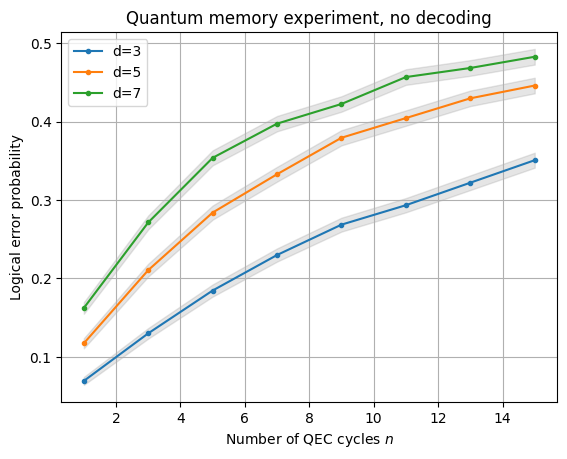

In [5]:
fig = plt.figure()

uncertainty_bar = 2  # Number of standard deviations to plot as error bars
for d, exp_vals in expectation_vals.items():
    plt.plot(n_rep, exp_vals[:, 0], marker="o", markersize=3, label=f"d={d}")
    plt.fill_between(
        n_rep,
        exp_vals[:, 0] + uncertainty_bar * exp_vals[:, 1],
        exp_vals[:, 0] - uncertainty_bar * exp_vals[:, 1],
        color="gray",
        alpha=0.2,
    )

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer ticks on x-axis

plt.xlabel(r"Number of QEC cycles $n$")
plt.ylabel("Logical error probability")
plt.title("Quantum memory experiment, no decoding")
plt.legend()
plt.grid()
plt.show()